# Price Prediction of Used Cars

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from math import isnan
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


### Data Exploration

In [2]:
df = pd.read_csv('USA_cars_datasets.csv', index_col=0)

In [3]:
print(f'shape: {df.shape}')
df.head()


shape: (2499, 12)


,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


In [4]:
df.isnull().sum()

price           0
brand           0
model           0
year            0
title_status    0
mileage         0
color           0
vin             0
lot             0
state           0
country         0
condition       0
dtype: int64

In [5]:
df.describe()

,price,year,mileage,lot
count,2499.000000,2499.000000,2.499000e+03,2.499000e+03
mean,18767.671469,2016.714286,5.229869e+04,1.676914e+08
std,12116.094936,3.442656,5.970552e+04,2.038772e+05
min,0.000000,1973.000000,0.000000e+00,1.593488e+08
25%,10200.000000,2016.000000,2.146650e+04,1.676253e+08
50%,16900.000000,2018.000000,3.536500e+04,1.677451e+08
75%,25555.500000,2019.000000,6.347250e+04,1.677798e+08
max,84900.000000,2020.000000,1.017936e+06,1.678055e+08


The numeric variables are price, mileage and year. Lot doesn't tell as a lot and is not really numeric, as it's a rather random number set by the car producing company.

In [6]:
for col in [categorical for categorical in df.columns if categorical not in df.describe().columns]:
    print(f'column {col}, {len(df[col].unique())} unique values')

column brand, 28 unique values
column model, 127 unique values
column title_status, 2 unique values
column color, 49 unique values
column vin, 2495 unique values
column state, 44 unique values
column country, 2 unique values
column condition, 47 unique values


We can get rid of the variable vin, as it is almost unique for each entry, and judging from the table above it is something similar to a serial number.

In [7]:
len(df.lot.unique())

2495

* As thought, lot is not a useful variable, so we'll get rid of it as well.

* Regarding the categorical variables, most have a lot of categories, and only title_status and condition seem easily ordinable. The rest should be one-hot encoded in order for the to be fed into the regression, although that will heavily increase the number of variables.

* Wit a regression with variable selection (LASSO) we might find out that some of these categories are only important when they take certain variables (i.e., only certain brands of cars)

In [8]:
df.drop(['vin', 'lot'], axis=1, inplace=True)

In [9]:
df.head()

,price,brand,model,year,title_status,mileage,color,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,florida,usa,22 hours left


#### Categorical Variables

In [10]:
df.title_status.unique()


array(['clean vehicle', 'salvage insurance'], dtype=object)

In [11]:
df.condition.unique()

array(['10 days left', '6 days left', '2 days left', '22 hours left',
       '20 hours left', '19 hours left', '3 days left', '21 hours left',
       '17 hours left', '2 hours left', '3 hours left', '34 minutes',
       '16 hours left', '18 hours left', '1 days left', '32 minutes',
       '14 hours left', '5 hours left', '4 days left', '9 days left',
       '23 hours left', '8 days left', '7 days left', '5 days left',
       '9 minutes', '1 minutes', '7 hours left', '16 minutes',
       '6 hours left', '1 hours left', 'Listing Expired', '13 days left',
       '24 hours left', '15 hours left', '53 minutes', '27 minutes',
       '12 days left', '15 days left', '30 minutes', '29 minutes',
       '28 minutes', '48 minutes', '11 days left', '4 hours left',
       '47 minutes', '12 hours left', '36 minutes'], dtype=object)

* title_status is not quite ordinable
* condition can be turned into a numeric variable, we'll choose the unit as minutes

the variables brand and model can probably be grouped somehow, we'll investigate these next

In [12]:
brand_freq = df.brand.value_counts().apply(lambda x: x / df.shape[0])
brand_freq

ford               0.494198
dodge              0.172869
nissan             0.124850
chevrolet          0.118848
gmc                0.016807
jeep               0.012005
chrysler           0.007203
bmw                0.006803
hyundai            0.006002
kia                0.005202
buick              0.005202
infiniti           0.004802
honda              0.004802
cadillac           0.004002
mercedes-benz      0.004002
heartland          0.002001
land               0.001601
peterbilt          0.001601
audi               0.001601
acura              0.001200
lincoln            0.000800
lexus              0.000800
mazda              0.000800
maserati           0.000400
toyota             0.000400
harley-davidson    0.000400
jaguar             0.000400
ram                0.000400
Name: brand, dtype: float64

Most brands barely appear. We could get rid of most of them, but there are some luxury brands that are very uncommon. Precisely luxury brands could have a substantial impact on the price.

## Reformat Variables

#### Condition

We'll begin by converting the condition variable into a numerical one, measured in minutes, as mentioned above.

In [13]:
df.head()

,price,brand,model,year,title_status,mileage,color,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,florida,usa,22 hours left


In [14]:
def convert_condition(string):
    convert = ''
    min_count = 0

    for i, e in enumerate(string):
        try:
            int(e)

        except ValueError:
            if (i == len(string)-1):
                break
            if convert != '':                
                if string[i+1] == 'd':
                    min_count += (int(convert) * 24 * 60)
                elif string[i+1] == 'h':
                    min_count += (int(convert) * 60)
                elif string[i+1] == 'm':
                    min_count += (int(convert))
            convert = ''

        else:
            convert = convert + e
            
    return min_count


In [15]:
df['condition'] = df['condition'].apply(convert_condition)

#### Title Status

Formated as 0-1 binary variable

In [16]:
df.title_status.unique()

array(['clean vehicle', 'salvage insurance'], dtype=object)

In [17]:
df.loc[df.loc[:, 'title_status'] == 'clean vehicle', 'title_status'] = 1
df.loc[df.loc[:, 'title_status'] == 'salvage insurance', 'title_status'] = 0
df.title_status = pd.to_numeric(df.title_status)

In [18]:
df.head()

,price,brand,model,year,title_status,mileage,color,state,country,condition
0,6300,toyota,cruiser,2008,1,274117.0,black,new jersey,usa,14400
1,2899,ford,se,2011,1,190552.0,silver,tennessee,usa,8640
2,5350,dodge,mpv,2018,1,39590.0,silver,georgia,usa,2880
3,25000,ford,door,2014,1,64146.0,blue,virginia,usa,1320
4,27700,chevrolet,1500,2018,1,6654.0,red,florida,usa,1320


#### Country

In [19]:
df.country.unique()

array([' usa', ' canada'], dtype=object)

In [20]:
df.loc[df.loc[:, 'country'] == ' canada', 'country'] = 1
df.loc[df.loc[:, 'country'] == ' usa', 'country'] = 0
df.country = pd.to_numeric(df.country)

In [21]:
df.head()

,price,brand,model,year,title_status,mileage,color,state,country,condition
0,6300,toyota,cruiser,2008,1,274117.0,black,new jersey,0,14400
1,2899,ford,se,2011,1,190552.0,silver,tennessee,0,8640
2,5350,dodge,mpv,2018,1,39590.0,silver,georgia,0,2880
3,25000,ford,door,2014,1,64146.0,blue,virginia,0,1320
4,27700,chevrolet,1500,2018,1,6654.0,red,florida,0,1320


* We are left over with categorical variables brand, model, color and state.
* They'll be one-hot encoded
* We'll try a simple linear regression without them first, and then Lasso, Ridge and Elastic Net with them

#### Brand

In [35]:
enc = OneHotEncoder(sparse = False)

In [37]:
enc.fit_transform(np.asarray(df['brand']).reshape(-1, 1))

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
enc = OneHotEncoder(sparse = False)
enc_code = enc.fit_transform(np.asarray(df['brand']).reshape(-1, 1))
enc_code
print("{} categories.\nCategory columns by order: \n\n{}".format(len(enc.categories_[0]), enc.categories_))

28 categories.
Category columns by order: 

[array(['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet',
       'chrysler', 'dodge', 'ford', 'gmc', 'harley-davidson', 'heartland',
       'honda', 'hyundai', 'infiniti', 'jaguar', 'jeep', 'kia', 'land',
       'lexus', 'lincoln', 'maserati', 'mazda', 'mercedes-benz', 'nissan',
       'peterbilt', 'ram', 'toyota'], dtype=object)]


In [23]:
code_df1 = pd.DataFrame(enc_code, columns = enc.categories_[0])

In [24]:
df2 = df.copy()
location = df.columns.get_loc('brand')

for i in code_df1.columns:
    df2.insert(location, column = i, value = code_df1[i].values)
    
df2.drop('brand', axis = 1, inplace = True)
df2.head()

,price,toyota,ram,peterbilt,nissan,mercedes-benz,mazda,maserati,lincoln,lexus,...,audi,acura,model,year,title_status,mileage,color,state,country,condition
0,6300,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,cruiser,2008,1,274117.0,black,new jersey,0,14400
1,2899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,se,2011,1,190552.0,silver,tennessee,0,8640
2,5350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,mpv,2018,1,39590.0,silver,georgia,0,2880
3,25000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,door,2014,1,64146.0,blue,virginia,0,1320
4,27700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1500,2018,1,6654.0,red,florida,0,1320


In [25]:
'brand' in df2.columns

False

#### Model

In [26]:
enc = OneHotEncoder(sparse = False)
enc_code = enc.fit_transform(np.asarray(df['model']).reshape(-1, 1))
enc_code
print("{} categories.\nCategory columns by order: \n\n{}".format(len(enc.categories_[0]), enc.categories_))

127 categories.
Category columns by order: 

[array(['1500', '2500', '2500hd', '300', '3500', '5', 'acadia', 'altima',
       'armada', 'bus', 'cab', 'camaro', 'caravan', 'cargo', 'challenger',
       'charger', 'chassis', 'cherokee', 'colorado', 'compass', 'connect',
       'convertible', 'corvette', 'country', 'coupe', 'cruiser', 'cruze',
       'cutaway', 'cx-3', 'd', 'dart', 'discovery', 'door', 'doors', 'dr',
       'drw', 'durango', 'e-class', 'ecosport', 'edge', 'el', 'elantra',
       'enclave', 'encore', 'energi', 'equinox', 'escape', 'esv',
       'expedition', 'explorer', 'f-150', 'f-650', 'f-750', 'fiesta',
       'flex', 'focus', 'forte', 'frontier', 'fusion', 'ghibli', 'glc',
       'gle', 'gx', 'hybrid', 'impala', 'journey', 'juke', 'kicks', 'ld',
       'limited', 'm', 'malibu', 'max', 'maxima', 'mdx', 'mpv', 'murano',
       'mustang', 'nautilus', 'note', 'nvp', 'pacifica', 'passenger',
       'pathfinder', 'pickup', 'pioneer', 'pk', 'q5', 'q70', 'ranger',
       'road

In [27]:
code_df1 = pd.DataFrame(enc_code, columns = enc.categories_[0])

In [28]:
code_df1.columns.get_loc('country')
code_df1.rename(columns={"country": "heartland_country"}, inplace=True)

In [29]:

df2 = pd.concat([df2, code_df1], axis=1)#  pd.concat([df1, df4], axis=1)
    
df2.drop('model', axis = 1, inplace = True)


In [30]:
df2.shape

(2499, 163)

#### Color

In [31]:
enc = OneHotEncoder(sparse = False)
enc_code = enc.fit_transform(np.asarray(df['color']).reshape(-1, 1))
enc_code
print("{} categories.\nCategory columns by order: \n\n{}".format(len(enc.categories_[0]), enc.categories_))

49 categories.
Category columns by order: 

[array(['beige', 'billet silver metallic clearcoat', 'black',
       'black clearcoat', 'blue', 'bright white clearcoat', 'brown',
       'burgundy', 'cayenne red', 'charcoal', 'color:',
       'competition orange', 'dark blue', 'glacier white', 'gold', 'gray',
       'green', 'guard', 'ingot silver', 'ingot silver metallic',
       'jazz blue pearlcoat', 'kona blue metallic', 'light blue',
       'lightning blue', 'magnetic metallic', 'maroon', 'morningsky blue',
       'no_color', 'off-white', 'orange', 'oxford white', 'pearl white',
       'phantom black', 'purple', 'red',
       'royal crimson metallic tinted clearcoat', 'ruby red',
       'ruby red metallic tinted clearcoat', 'shadow black', 'silver',
       'super black', 'tan', 'toreador red', 'triple yellow tri-coat',
       'turquoise', 'tuxedo black metallic', 'white',
       'white platinum tri-coat metallic', 'yellow'], dtype=object)]


In [32]:
code_df1 = pd.DataFrame(enc_code, columns = enc.categories_[0])

In [33]:
df2 = pd.concat([df2, code_df1], axis=1)
df2.drop('color', axis = 1, inplace = True)
df2.shape

(2499, 211)

#### State

In [34]:
enc = OneHotEncoder(sparse = False)
enc_code = enc.fit_transform(np.asarray(df['state']).reshape(-1, 1))
enc_code
print("{} categories.\nCategory columns by order: \n\n{}".format(len(enc.categories_[0]), enc.categories_))

44 categories.
Category columns by order: 

[array(['alabama', 'arizona', 'arkansas', 'california', 'colorado',
       'connecticut', 'florida', 'georgia', 'idaho', 'illinois',
       'indiana', 'kansas', 'kentucky', 'louisiana', 'maryland',
       'massachusetts', 'michigan', 'minnesota', 'mississippi',
       'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire',
       'new jersey', 'new mexico', 'new york', 'north carolina', 'ohio',
       'oklahoma', 'ontario', 'oregon', 'pennsylvania', 'rhode island',
       'south carolina', 'tennessee', 'texas', 'utah', 'vermont',
       'virginia', 'washington', 'west virginia', 'wisconsin', 'wyoming'],
      dtype=object)]


In [35]:
code_df1 = pd.DataFrame(enc_code, columns = enc.categories_[0])

In [36]:
df2 = pd.concat([df2, code_df1], axis=1)
df2.drop('state', axis = 1, inplace = True)
df2.shape

(2499, 254)

# Prediction

* Note: When rerunning the notebook, results may change slightly (MSE, MAE values, etc.)

## Simple linear regression with small subset of variables

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [38]:
variables = ['year', 'title_status', 'mileage', 'country', 'condition']


In [39]:
X_train, X_test, y_train, y_test = train_test_split(df[variables], df.price, train_size=0.8)

In [40]:
cv_results = cross_validate(LinearRegression(), X_train, y_train, cv=5, return_estimator=True)

In [41]:
print(f'R^2: {max(cv_results["test_score"])}',
      f'MSE: {sum((cv_results["estimator"][np.argmax(cv_results["test_score"])].predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(cv_results["estimator"][np.argmax(cv_results["test_score"])].predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

R^2: 0.2296957159161409
MSE: 117226857.71708679
MAE: 8247.818577080747


* The $R^2$ result we have is quite low
* The MSE is extremely high, but the alternative MAE is lower
* The output variable has a range of $[0, ~85000]$, a mean of ~18000, median of ~17000 and standard deviation of ~12000
* Given the scale of the variable and the wide range, the MSE can take on large values easily, so the MAE might be a better measure
* Still, the outputed MAE seems high

## Lasso

In [ ]:
from sklearn.linear_model import LassoCV

In [43]:
variables = [i for i in df2.columns if i != 'price']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df2[variables], df.price, train_size=0.8)

In [45]:
lassocv_model = LassoCV(alphas=np.arange(1, 5, 0.2), max_iter=5000, tol=0.0001, cv=5, random_state=0).fit(X_train, y_train)

In [46]:
print(f'best penalization term: {lassocv_model.alpha_}',
      f'R^2: {lassocv_model.score(X_test, y_test)}',
      f'MSE: {sum((lassocv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(lassocv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')


best penalization term: 3.7999999999999994
R^2: 0.6578011213114658
MSE: 50190444.05038542
MAE: 4744.997833456841


* With Lasso we get much better results for all measures
* $R^2$ is considerably higher
* We still get a high value for the MSE, probably attributable to the scale and spread of the data
* The MAE is considerably lower, and a more acceptable vale given the scale of the price variable

### Ridge

In [47]:
from sklearn.linear_model import RidgeCV

In [48]:
ridgecv_model = RidgeCV(alphas=np.arange(0, 2, 0.1), cv=5).fit(X_train, y_train)

In [49]:
print(f'best penalization term: {ridgecv_model.alpha_}',
      f'R^2: {ridgecv_model.score(X_test, y_test)}',
      f'MSE: {sum((ridgecv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(ridgecv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

best penalization term: 0.8
R^2: 0.6649044869173508
MSE: 49148590.624745995
MAE: 4730.294654262457


* We get an improvement of the same scale as with Lasso. In previous runnings of the notebook, the results for ridge were slightly better, but by a very small difference

### Elastic Net

In [50]:
from sklearn.linear_model import ElasticNetCV

In [51]:
elasticnetcv_model = ElasticNetCV(l1_ratio=np.arange(0.15, 1, 0.15), alphas=np.arange(0.5, 3.6, 0.2), cv=5).fit(X_train, y_train)

In [52]:
print(f'best L1 penalizatoin term: {elasticnetcv_model.alpha_*(elasticnetcv_model.l1_ratio_)}',
      f'best L2 penalizatoin term: {elasticnetcv_model.alpha_*(1-elasticnetcv_model.l1_ratio_)}',
      f'R^2: {elasticnetcv_model.score(X_test, y_test)}',
      f'MSE: {sum((elasticnetcv_model.predict(X_test) - y_test)**2) / len(y_test)}',
      f'MAE: {sum(abs(elasticnetcv_model.predict(X_test) - y_test)) / len(y_test)}',
      sep='\n')

best L1 penalizatoin term: 0.45
best L2 penalizatoin term: 0.04999999999999999
R^2: 0.47225167532518963
MSE: 77405054.2298379
MAE: 6397.481765293769


* When using both penalizations together the result is worse, as both MSE and MAE are higher, and $R^2$ is lower than with Lasso or Ridge standalone

### Model comparison and variable selection


* Ridge and Lasso both provide the best results.
* However, one advantage of Lasso is that it shrinks coefficients to 0, making the model simpler and allowing us to focus in the most important variables
* For this reason, Lasso might be a preferrable model

In [53]:
print(f'Coefficients shrunk to 0 by Lasso: {sum(lassocv_model.coef_ == 0)}',
      f'Coefficients shrunk to 0 by Ridge: {sum(ridgecv_model.coef_ == 0)}',
      f'Coefficients shrunk to 0 by Elastic Net: {sum(elasticnetcv_model.coef_ == 0)}',
      sep='\n')
    
    

Coefficients shrunk to 0 by Lasso: 87
Coefficients shrunk to 0 by Ridge: 11
Coefficients shrunk to 0 by Elastic Net: 17


* In this case we see Ridge has also shrunken a few coefficients to $0$, perhaps because they are of no importance at all
* However, Lasso has shrunken way more of the original predictors. In the different runs of the notebook it removed $~25-30\%$ of the original $255$ predictors,  making the model considerably simpler

## Extra - Vehicle Brands

* When exploring the data set the difference in brands and models was mentioned briefly
* This probably has an important effect but due to lack of time it wasn't studied in detail
* Trying to perform clustering might show subgroups of brands or models for which customers are willing to pay more
* This could be for reducing dimensions, and feed cluster classification to the price regression instead of brand and model
* If we look at the plots below, there are brands get consistently higher prices than others (e.g. Ford compared to Nissan)
* Also, in the plot with the few sales of luxury vehicles, we see that they are on the higher end of prices across all years

In [54]:
lux = {'audi', 'harley-davidson', 'jaguar', 'maserati', 'lexus', 'cadillac', 'mercedes-benz', 'bmw', 'acura'}

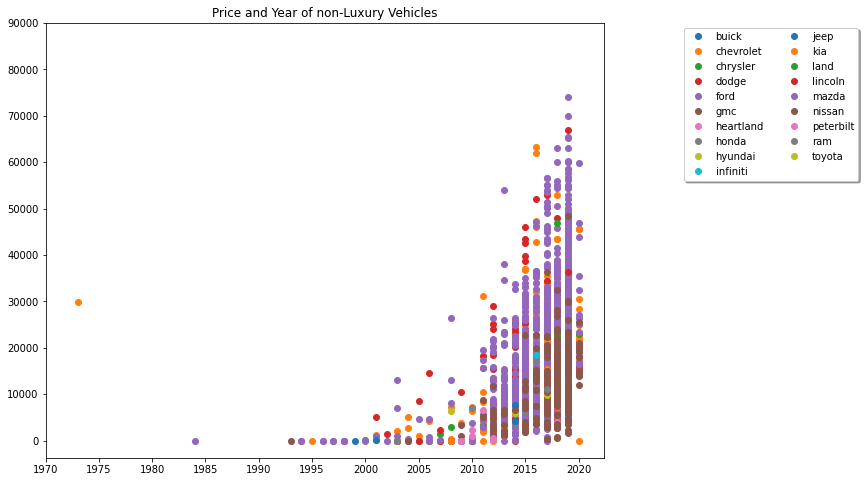

In [55]:
fig = plt.figure(figsize=(10, 8))

groups = df[~df.brand.isin(lux)].groupby("brand")
for name, group in groups:
    plt.plot(group["year"], group["price"], marker="o", linestyle="", label=name)

plt.title('Price and Year of non-Luxury Vehicles')
plt.yticks(range(0, 100000, 10000))
plt.xticks(range(1970, 2025, 5))
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=2)

plt.show()

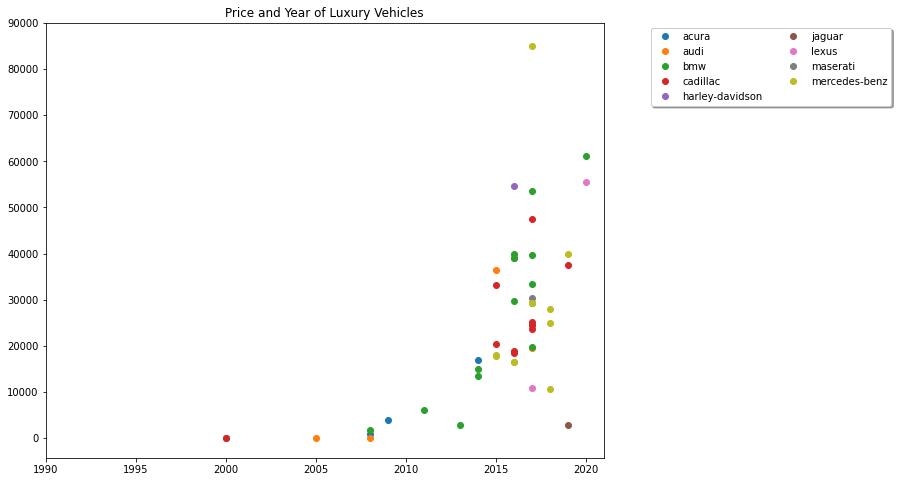

In [56]:
fig = plt.figure(figsize=(10, 8))

groups = df[df.brand.isin(lux)].groupby("brand")
for name, group in groups:
    plt.plot(group["year"], group["price"], marker="o", linestyle="", label=name)

plt.title('Price and Year of Luxury Vehicles')
plt.yticks(range(0, 100000, 10000))
plt.xticks(range(1990, 2025, 5))
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=2)

plt.show()

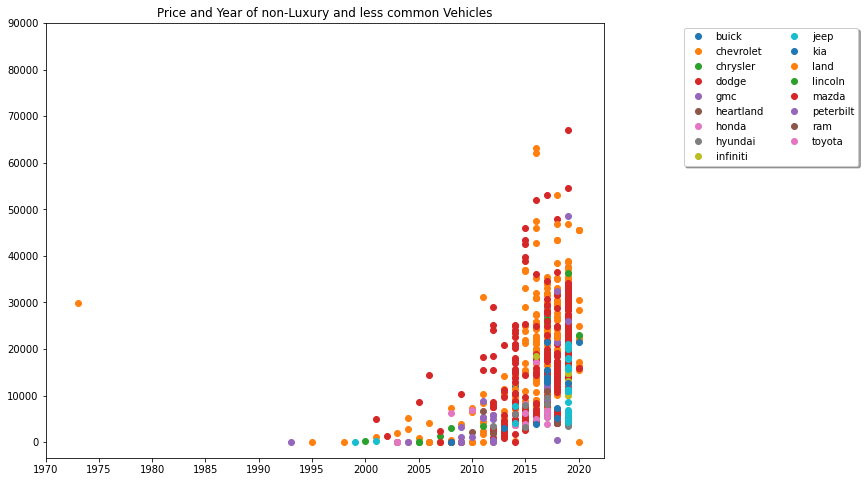

In [57]:
exclude = list(lux)
exclude.append('ford')
exclude.append('nissan')
fig = plt.figure(figsize=(10, 8))

groups = df[~df.brand.isin(exclude)].groupby("brand")
for name, group in groups:
    plt.plot(group["year"], group["price"], marker="o", linestyle="", label=name)

plt.title('Price and Year of non-Luxury and less common Vehicles')
plt.yticks(range(0, 100000, 10000))
plt.xticks(range(1970, 2025, 5))
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=2)

plt.show()